In [27]:
#? load libraries
import cv2
import numpy as np
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

In [18]:
#? define global variables
MODEL_PATH = './models/ocr_smooth'
IMAGE_PATH = './tests/Alphabetic.png'
LABEL_PATH = './lables.txt'

In [3]:
#? load the model
model = load_model(MODEL_PATH)

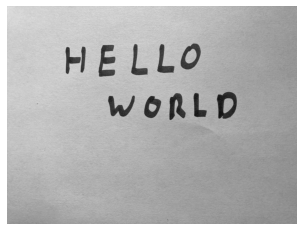

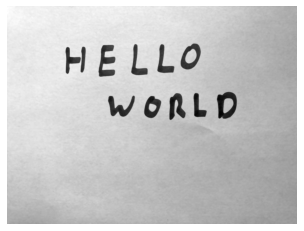

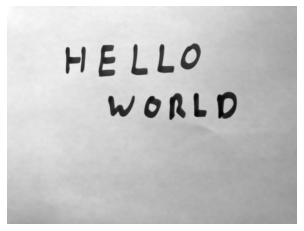

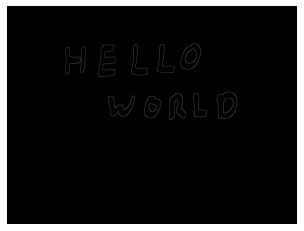

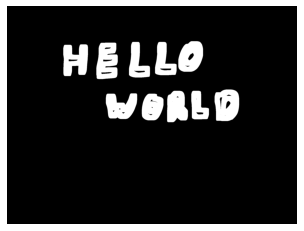

In [49]:
#? load and pre-process the image
img_raw = cv2.imread(IMAGE_PATH, 0)

# blur the image
img_blured = cv2.medianBlur(img_raw, 11)

# denoise the image
img_denoised = cv2.fastNlMeansDenoising(img_blured, 11, 21, 35)

# highlight the edges and make them more pronounced
edged = cv2.Canny(img_denoised, 30, 150)
kernel = np.ones((5,5),np.uint8)
img_dialated = cv2.dilate(edged, kernel, iterations = 8)

# find and sort the edges
cnts = cv2.findContours(img_dialated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sorted_ctrs = sort_contours(cnts, method="left-to-right")[0]

plt.imshow(img_raw, 'gray')
plt.axis('off')
plt.show()
plt.imshow(img_blured, 'gray')
plt.axis('off')
plt.show()
plt.imshow(img_denoised, 'gray')
plt.axis('off')
plt.show()
plt.imshow(edged, 'gray')
plt.axis('off')
plt.show()
plt.imshow(img_dialated, 'gray')
plt.axis('off')
plt.show()

In [50]:
#? get all the contours
chars = []

# loop over the contours
for c in sorted_ctrs:

    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)

    # filter out bounding boxes, ensuring they are neither too small nor too large
    if w > 15 and h > 15 and w < 600 and h < 600:

        # extract the char's image
        img_raw = img_denoised[y:y+h, x:x+w]

        # resize the maximum dimension of the image to 32
        if w > h:
            img_raw = imutils.resize(img_raw, width=32)
        else: # otherwise, resize along the height
            img_raw = imutils.resize(img_raw, height=32)

        # pad the image to force it's size to be 32x32
        (tH, tW) = img_raw.shape
        dX = int(max(0, 32 - tW) / 2.0)
        dY = int(max(0, 32 - tH) / 2.0)

        img_padded = cv2.copyMakeBorder(img_raw, top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
        img_padded = cv2.resize(img_padded, (32, 32))

        # invert the image and binarize it
        ret, img_binarized = cv2.threshold(img_padded, 127, 1, cv2.THRESH_BINARY_INV)

        # prepare the image for classification
        img_binarized = img_binarized.astype("float32")

        # update our list of characters that will be OCR'd
        chars.append((img_binarized, (x, y, w, h)))

In [57]:
# make sure that no bounding boxes are completely contained by another
valid_chars = []
for c1 in chars:

    x1, y1,  = c1[1]
    outside = True
    for c2 in chars:

        x2, y2, w2, h2 = c2[1]
        if (x1 > x2 and y1 > y2 and x1+w1 < x2+w2 and y1+h1 < y2+h2):
            outside = False
            break
    
    if outside:
        valid_chars.append(c1)

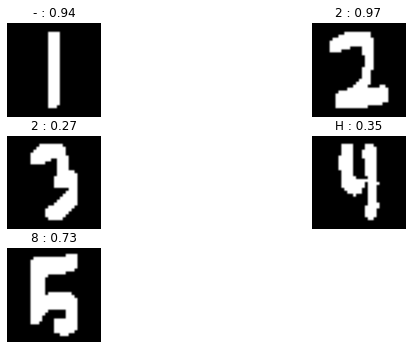

In [58]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in ]

inputs = np.array([c[0] for c in valid_chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(inputs.reshape((-1, 32, 32, 1)))

#? create a lable dictionary
lables_raw = open(LABEL_PATH).read()
lables_split = lables_raw.split('\n')
lables = [chr((int)(c)) for c in lables_split]

fig = plt.figure(figsize=(10, 10))

rows = 5
cols = int(len(inputs) / rows) + 1

for i in range(len(inputs)):

    fig.add_subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(inputs[i], 'gray')
    plt.title(f'{lables[preds[i].argmax()]} : {round(preds[i].max()*100)/100}')
    plt.clim(0, 1)

plt.show()